### ALEX CECCOTTI - 790497
### CHALLENGE TECHNOLOGICAL INFRASTRUCTURES

Importo il dataset

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

df = sqlContext.read.format('com.databricks.spark.csv').\
        options(header='true', delimiter=";", inferschema='true').load('risultati_totali.csv')

In [2]:
df

DataFrame[F1: int, F2: int, F3: int, F4: string, Rep: int, M_OF: int, M_TIME(s): string, CBC_OF: int, CBC_TIME: string, CBC_#FEASIBILITY CUTS: int, CBC_# PENALTY CUTS: int, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string]

In [3]:
df.take(3)

[Row(F1=3, F2=400, F3=9, F4='A', Rep=1, M_OF=361, M_TIME(s)='0,266', CBC_OF=361, CBC_TIME='0,462', CBC_#FEASIBILITY CUTS=0, CBC_# PENALTY CUTS=0, _c11=None, _c12=None, _c13=None, _c14=None, _c15=None, _c16=None, _c17=None, _c18=None),
 Row(F1=3, F2=400, F3=9, F4='A', Rep=2, M_OF=306, M_TIME(s)='0,511', CBC_OF=306, CBC_TIME='0,106', CBC_#FEASIBILITY CUTS=0, CBC_# PENALTY CUTS=0, _c11=None, _c12=None, _c13=None, _c14=None, _c15=None, _c16=None, _c17=None, _c18=None),
 Row(F1=3, F2=400, F3=9, F4='A', Rep=3, M_OF=271, M_TIME(s)='1,052', CBC_OF=271, CBC_TIME='1,646', CBC_#FEASIBILITY CUTS=0, CBC_# PENALTY CUTS=4, _c11=None, _c12=None, _c13=None, _c14=None, _c15=None, _c16=None, _c17=None, _c18=None)]

Ci sono delle variabili che assumono valore None e il tempo di esecuzione dei due algoritmi è codificato come stringa

In [4]:
from pyspark.sql.functions import udf
commadot_udf = udf(lambda x: float(x.replace(",",".")), DoubleType())

In [5]:
my_cols = df.columns[0:11]
my_data = df.select(my_cols).withColumn("M_TIME(s)", commadot_udf("M_TIME(s)")).withColumn("CBC_TIME", commadot_udf("CBC_TIME"))
my_data = my_data.withColumnRenamed("M_TIME(s)", "M_TIME")
my_data.cache()

DataFrame[F1: int, F2: int, F3: int, F4: string, Rep: int, M_OF: int, M_TIME: double, CBC_OF: int, CBC_TIME: double, CBC_#FEASIBILITY CUTS: int, CBC_# PENALTY CUTS: int]

#### Esercizio 1

In [6]:
my_data.describe().toPandas()

,summary,F1,F2,F3,F4,Rep,M_OF,M_TIME,CBC_OF,CBC_TIME,CBC_#FEASIBILITY CUTS,CBC_# PENALTY CUTS
0,count,360,360,360,360,360,360,360,360,360,360,360
1,mean,6.0,500.0,9.155555555555555,None,5.5,271.575,105.1211083333333,270.85833333333335,87.07493888888881,0.019444444444444445,4.852777777777778
2,stddev,2.9480176050089826,81.76329719869562,1.6295400592512068,None,2.8762789331691674,98.3542284190714,494.4580101423188,98.25782943139056,382.6576333540671,0.15713210460545812,10.1040819162897
3,min,3,400,6,A,1,82,0.08,82,0.01,0,0
4,max,10,600,14,D,10,658,3600.0,658,3600.0,2,73


Le variabili numeriche vengono descritte bene, ma la variabile "F4" che è categorica va analizzata meglio

In [7]:
my_data.groupBy("F4").count().show()

+---+-----+
| F4|count|
+---+-----+
|  B|   90|
|  D|   90|
|  C|   90|
|  A|   90|
+---+-----+



#### Esercizio 2

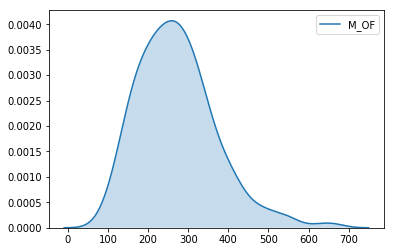

In [9]:
import seaborn as sns
pand_data = my_data.select("M_OF","CBC_OF").toPandas()
sns.kdeplot(pand_data["M_OF"], shade=True)

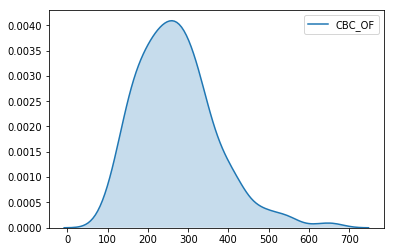

In [10]:
sns.kdeplot(pand_data["CBC_OF"], shade=True)

Le due distribuzioni sono praticamente identiche

Lo si può notare anche dai seguenti violinplot messi a confronto

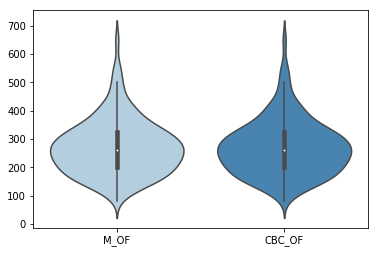

In [11]:
sns.violinplot(data=pand_data[["M_OF","CBC_OF"]], palette="Blues")

Dato che si tratta di campioni appaiati, dovrei eseguire un test T sulla media delle differenze delle due variabili

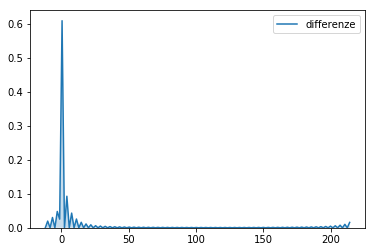

In [12]:
def diff(x,y):
    return x-y
diff_udf = udf(diff, IntegerType())
my_samp = my_data.select(diff_udf("M_OF","CBC_OF")).withColumnRenamed('diff(M_OF, CBC_OF)', 'differenze').toPandas()
sns.kdeplot(my_samp["differenze"], shade=True)

La distribuzione non sembra essere normale, dunque non posso utilizzare un test T sulla media delle differenze (test utilizzato per campioni appaiati)

In [13]:
from scipy.stats import shapiro
shapiro(my_samp["differenze"])

(0.04292076826095581, 8.479880585446093e-39)

L'ipotesi di normalità viene infatti rifiutata dallo shapiro test

Proviamo dunque ad effettuare in spark un test non parametrico basato sulla mediana

In [14]:
m_of = my_data.select("M_OF")
cbc_of = my_data.select("CBC_OF")
total_of = m_of.union(cbc_of)
median = total_of.approxQuantile("M_OF", [0.5], 0)[0]
m_down = m_of.filter(m_of["M_OF"]<median).count()
cbc_down = cbc_of.filter(cbc_of["CBC_OF"]<median).count()
n = m_of.count()

Viene calcolata la mediana sulla totalità delle istanze (osservazioni di M e CBC insieme), per ognuno dei due algoritmi si contano le istanza con valore inforiore e superiore alla mediana appena calcolata e infine si effettua un test chi-quadrato sulla tabella di contigenze ottenuta

In [15]:
from scipy.stats import chi2_contingency as chi_test
chi_test([[m_down, n-m_down],[cbc_down, n-cbc_down]])[1]

1.0

Il p-value è approssimato a 1, dunque posso accettare l'ipotesi che i due campioni siano estratti da popolazioni che hanno mediane coincidenti

In termini di performance non riesco quindi a decidere quale dei due algoritmi sia il migliore

#### Esercizio 3

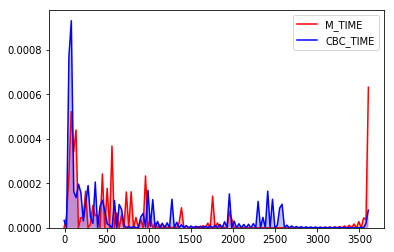

In [16]:
pand_data2 = my_data.select("M_TIME","CBC_TIME").toPandas()
p1=sns.kdeplot(pand_data2["M_TIME"], shade=True, color="r")
p1=sns.kdeplot(pand_data2["CBC_TIME"], shade=True, color="b")

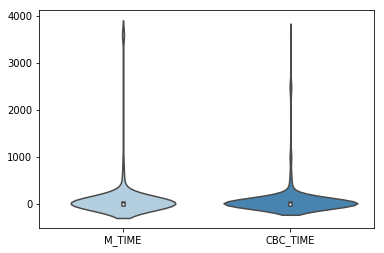

In [17]:
sns.violinplot(data=pand_data2[["M_TIME","CBC_TIME"]], palette="Blues")

In questo caso le distribuzioni sembrano essere diverse, anche se simili

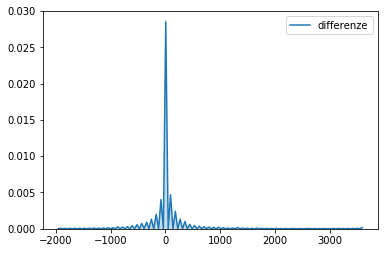

In [18]:
diff_udf = udf(diff, DoubleType())
my_samp2 = my_data.select(diff_udf("M_TIME","CBC_TIME")).withColumnRenamed('diff(M_TIME, CBC_TIME)', 'differenze').toPandas()
sns.kdeplot(my_samp2["differenze"], shade=True)

In [19]:
shapiro(my_samp2["differenze"])

(0.2632717490196228, 2.2766389709409908e-35)

Anche in questo caso rifiuto l'ipotesi di normalità delle differenze e non posso dunque effettuare un test T

Rieseguo con queste variabili il test non parametrico visto in precedenza

In [20]:
m_time = my_data.select("M_TIME")
cbc_time = my_data.select("CBC_TIME")
total_time = m_time.union(cbc_time)
median2 = total_time.approxQuantile("M_TIME", [0.5], 0)[0]
m_down2 = m_time.filter(m_time["M_TIME"]<median2).count()
cbc_down2 = cbc_time.filter(cbc_time["CBC_TIME"]<median2).count()

In [21]:
chi_test([[m_down2, n-m_down2],[cbc_down2, n-cbc_down2]])[1]

1.8134240346021896e-07

Il p-value è molto prossimo allo 0, dunque non posso accettare l'ipotesi che i due campioni siano estratti da popolazioni che hanno mediane coincidenti

In [22]:
[m_down2, cbc_down2]

[144, 215]

L'argoritmo CBC sembra essere il migliore in quanto ha più osservazioni con valore della variabile TIME sotto la mediana della totalità delle istanze

#### Esercizio 4

In [23]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

col_names = my_data.columns
del col_names[3]

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)
df_vector = assembler.transform(my_data).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

In [24]:
import pandas as pd
corr_matrix = round(pd.DataFrame(matrix.collect()[0][0].toArray()),3)
corr_matrix.columns = col_names
corr_matrix.index = col_names
corr_matrix

,F1,F2,F3,Rep,M_OF,M_TIME,CBC_OF,CBC_TIME,CBC_#FEASIBILITY CUTS,CBC_# PENALTY CUTS
F1,1.000,0.000,-0.071,0.000,-0.111,0.273,-0.121,0.293,0.126,0.387
F2,0.000,1.000,0.740,0.000,0.464,0.153,0.470,0.143,0.022,0.180
F3,-0.071,0.740,1.000,-0.007,0.577,0.188,0.579,0.180,0.086,0.217
Rep,0.000,0.000,-0.007,1.000,-0.041,0.032,-0.038,0.017,0.059,0.009
M_OF,-0.111,0.464,0.577,-0.041,1.000,0.167,0.993,0.206,0.008,0.157
M_TIME,0.273,0.153,0.188,0.032,0.167,1.000,0.168,0.722,0.128,0.551
CBC_OF,-0.121,0.470,0.579,-0.038,0.993,0.168,1.000,0.206,0.005,0.154
CBC_TIME,0.293,0.143,0.180,0.017,0.206,0.722,0.206,1.000,0.042,0.665
CBC_#FEASIBILITY CUTS,0.126,0.022,0.086,0.059,0.008,0.128,0.005,0.042,1.000,0.261
CBC_# PENALTY CUTS,0.387,0.180,0.217,0.009,0.157,0.551,0.154,0.665,0.261,1.000


La matrice appena ottenuta è la matrice di correlazione tra tutte le variabili (esclusa F4 in quanto categoriale)

In [25]:
from  pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import when

my_data_dummy = my_data.withColumn("F4_A", when(my_data.F4 == "A", 1).otherwise(0)).\
                withColumn("F4_B", when(my_data.F4 == "B", 1).otherwise(0)).\
                withColumn("F4_C", when(my_data.F4 == "C", 1).otherwise(0))

my_inp = ["F1","F2","F3","F4_A","F4_B","F4_C"]
assembler1 = VectorAssembler(
    inputCols=my_inp,
    outputCol='features')

my_lin_data = assembler1.transform(my_data_dummy).select("features", "M_TIME")

lr = LinearRegression(featuresCol = 'features', labelCol = 'M_TIME')

lr_model = lr.fit(my_lin_data)

Una volta ricodificata in dummies la variabile F4, stimo un modello di regressione lineare per M_TIME e visualizzo il suo summary

In [26]:
print("Variable \t Coefficient \t p-value")
for i in range(0,6):
    print(my_inp[i], "\t\t", round(lr_model.coefficients[i],3), " \t", round(lr_model.summary.pValues[i],3))
print("Intercept \t", round(lr_model.intercept,3), "\t", round(lr_model.summary.pValues[6],3))

Variable 	 Coefficient 	 p-value
F1 		 48.347  	 0.0
F2 		 -0.025  	 0.955
F3 		 64.573  	 0.003
F4_A 		 242.702  	 0.0
F4_B 		 -73.706  	 0.276
F4_C 		 -18.727  	 0.781
Intercept 	 -801.448 	 0.0


Le variabili significative con coefficiente maggiore sono F4_A (considerando F4_D come baseline), F3 e F1

In [27]:
my_lin_data2 = assembler1.transform(my_data_dummy).select("features", "CBC_TIME")

lr2 = LinearRegression(featuresCol = 'features', labelCol = 'CBC_TIME')

lr_model2 = lr2.fit(my_lin_data2)

Eseguo dunque lo stesso processo per CBC_TIME

In [28]:
print("Variable \t Coefficient \t p-value")
for i in range(0,6):
    print(my_inp[i], "\t\t", round(lr_model2.coefficients[i],3), " \t", round(lr_model2.summary.pValues[i],3))
print("Intercept \t", round(lr_model2.intercept,3), "\t", round(lr_model2.summary.pValues[6],3))

Variable 	 Coefficient 	 p-value
F1 		 39.943  	 0.0
F2 		 -0.065  	 0.84
F3 		 49.804  	 0.002
F4_A 		 267.913  	 0.0
F4_B 		 -45.86  	 0.362
F4_C 		 -35.885  	 0.475
Intercept 	 -622.438 	 0.0


Anche in questo caso valgono le stesse conclusioni del modello precedente